In [7]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from morphopy.computation import file_manager as fm
from morphopy.neurontree import NeuronTree as nt
import os
import re
import torch
from torch_geometric.utils.convert import from_networkx
from torch_geometric.data import Dataset, Data
import pandas as pd
from sklearn.preprocessing import LabelEncoder


In [8]:
GOUWENS_DIR = "/external/rprshnas01/netdata_kcni/stlab/Public/AIBS_patchseq_2020/mouse/morphology/download.brainlib.org+8811/biccn/zeng/pseq/morph/200526/"

In [9]:
def extract_id_from_file(filename):
    parts = filename.split("/")
    extracted_number = parts[-1].split("_")[0]

    return extracted_number

In [10]:
def extract_graph(filename):
    try:
        N = fm.load_swc_file(filename)
        _id = extract_id_from_file(filename)
        return (int(_id), N, N.get_graph())
    except ValueError:
        return -1

In [11]:
def get_id(filename):
    match = re.search(r'\d+', filename)
    if match:
        number = match.group()
        return number

In [12]:
def get_graphs(directory):
    file_list = []
    for file in os.listdir(directory):
        if file.endswith("_transformed.swc"):
            file_list.append(os.path.join(directory, file))
            
    return file_list

In [13]:
samples = get_graphs(GOUWENS_DIR)

# Load Gouwens Metadata

In [14]:
metadata_df = pd.read_csv('/nethome/kcni/aaulakh/morphology/metadata_gouwens.csv')

In [15]:
metadata_df.columns

Index(['Unnamed: 0', 'sample_id', 'project', 'cell_specimen_id',
       'cell_specimen_name', 'hemisphere', 'structure', 'donor_id',
       'donor_name', 'biological_sex', 'age', 'full_genotype', 'dendrite_type',
       'apical_dendrite_status', 'neuron_reconstruction_type',
       'cell_soma_normalized_depth', 'ephys_session_id',
       'transcriptomics_batch', 'corresponding_AIT2.3.1_ID',
       'corresponding_AIT2.3.1_alias', 'major_type', 'contam_type',
       'quality_score', 'Microglia', 'cluster_label'],
      dtype='object')

In [16]:
metadata_df['corresponding_AIT2.3.1_alias'].value_counts()

corresponding_AIT2.3.1_alias
Sst Calb2         321
Sst Hpse          310
Pvalb Reln        285
Sst Rxfp1         239
Lamp5 Lsp1        195
Pvalb Sema3e      176
Pvalb Tpbg        176
Sncg Vip          174
 NA               165
Vip Crispld2      155
Lamp5 Plch2       150
Sst Esm1          146
Sst Tac2          141
Sst Chodl         132
Vip Lmo1          130
Vip Ptprt         128
Sst Tac1          117
Sst Crhr2         116
Vip Pygm           99
Sst Myh8           79
Lamp5 Ntn1         73
Sst Mme            68
Pvalb Akr1c18      64
Vip Chat           63
Pvalb Th           55
Vip Col15a1        54
Sncg Gpr50         49
Sst Nts            47
Pvalb Gabrg1       46
Vip Rspo4          43
Sst Crh            42
Pvalb Calb1        38
Sst Nr2f2          37
Vip Arhgap36       36
Serpinf1 Aqp5      34
Vip Lect1          30
Sst Chrna2         29
Lamp5 Fam19a1      28
Pvalb Gpr149       24
Pvalb Vipr2        24
Vip Igfbp4         20
Vip Gpc3           20
Lamp5 Lhx6         19
Serpinf1 Clrn1     13
Snc

In [17]:
# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the corresponding labels
encoded_labels = label_encoder.fit_transform(metadata_df['corresponding_AIT2.3.1_alias'])

# Store the encoded labels back into the DataFrame
metadata_df['encoded_labels'] = encoded_labels

# Create a mapping dictionary of original labels to encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))


In [18]:
def create_pytorch_object(df, _id, g, neuron_tree):
    data = from_networkx(g, group_node_attrs=neuron_tree.get_node_attribute_names(), group_edge_attrs=neuron_tree.get_edge_attribute_names())
    
    subclass_label = df.loc[df['cell_specimen_id'] == _id, 'encoded_labels'].values[0]
    subclass_label = np.array([subclass_label], dtype=np.int64)
    data.y = torch.from_numpy(subclass_label)
    
    return data

In [19]:
data_objects = []

In [20]:
for s in samples:
    g_info = extract_graph(s)
    if g_info != -1:
        _id = g_info[0]
        neuron_tree = g_info[1]
        g = g_info[2]
        if len(list(nx.weakly_connected_components(g))) == 1:
            try:
                data_object = create_pytorch_object(metadata_df, _id, g, neuron_tree)
                data_objects.append(data_object)
            except ValueError:
                disconnected_nodes = [node for node in g.nodes() if not nx.node_connected_component(g, node)]
                print(f"Skipping graph {_id} due to disconnected nodes: {disconnected_nodes}")


/nethome/kcni/aaulakh/.anaconda3/envs/venv/lib/python3.11/site-packages/torch_geometric/utils/convert.py:249: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  data[key] = torch.tensor(value)


In [22]:
len(data_objects)

537

In [23]:
class MorphologyDataset(Dataset):
    def __init__(self, data_objects, transform=None):
        super().__init__(root=None, transform=transform)
        self.data_objects = data_objects

    def len(self):
        return len(self.data_objects)

    def get(self, idx):
        return self.data_objects[idx]

In [24]:
dataset = MorphologyDataset(data_objects, transform=None)

In [37]:
torch.save(dataset, '/nethome/kcni/aaulakh/morphology/gouwens_pyg_dataset.pt')

In [40]:
dataset = torch.load('/nethome/kcni/aaulakh/morphology/gouwens_pyg_dataset.pt')

In [41]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: MorphologyDataset(537):
Number of graphs: 537
Number of features: 5
Number of classes: 50

Data(edge_index=[2, 5839], x=[5840, 5], edge_attr=[5839, 2], y=[1])
Number of nodes: 5840
Number of edges: 5839
Average node degree: 1.00
Has isolated nodes: False
Has self-loops: False
Is undirected: False


In [42]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:376]
test_dataset = dataset[376:]

In [43]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 32
DataBatch(edge_index=[2, 297238], x=[297270, 5], edge_attr=[297238, 2], y=[32], batch=[297270], ptr=[33])

Step 2:
Number of graphs in the current batch: 32
DataBatch(edge_index=[2, 359625], x=[359657, 5], edge_attr=[359625, 2], y=[32], batch=[359657], ptr=[33])

Step 3:
Number of graphs in the current batch: 32
DataBatch(edge_index=[2, 315837], x=[315869, 5], edge_attr=[315837, 2], y=[32], batch=[315869], ptr=[33])

Step 4:
Number of graphs in the current batch: 32
DataBatch(edge_index=[2, 320336], x=[320368, 5], edge_attr=[320336, 2], y=[32], batch=[320368], ptr=[33])

Step 5:
Number of graphs in the current batch: 32
DataBatch(edge_index=[2, 354188], x=[354220, 5], edge_attr=[354188, 2], y=[32], batch=[354220], ptr=[33])

Step 6:
Number of graphs in the current batch: 32
DataBatch(edge_index=[2, 340758], x=[340790, 5], edge_attr=[340758, 2], y=[32], batch=[340790], ptr=[33])

Step 7:
Number of graphs in the current batch: 32
DataBatc

In [56]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, dropout_rate=0.5, l2_regularization=0.01):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)
        self.dropout_rate = dropout_rate
        self.l2_regularization = l2_regularization

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.lin(x)

        return x

    def l2_loss(self):
        l2_loss = 0
        for param in self.parameters():
            l2_loss += torch.norm(param, p=2)
        return l2_loss

    def loss(self, pred, target):
        return F.cross_entropy(pred, target) + self.l2_regularization * self.l2_loss()

In [57]:
data_objects[0]

Data(edge_index=[2, 5913], x=[5914, 5], edge_attr=[5913, 2], y=[1])

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [59]:
model = GCN(hidden_channels=64).to(device)
model.double()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = []
train_accuracies = []
test_accuracies = []
def train():
    model.double()
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 501):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    epochs.append(epoch)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.0904, Test Acc: 0.0745
Epoch: 002, Train Acc: 0.1223, Test Acc: 0.1801
Epoch: 003, Train Acc: 0.1330, Test Acc: 0.1739
Epoch: 004, Train Acc: 0.1356, Test Acc: 0.1863
Epoch: 005, Train Acc: 0.1782, Test Acc: 0.2174
Epoch: 006, Train Acc: 0.1915, Test Acc: 0.2174
Epoch: 007, Train Acc: 0.2021, Test Acc: 0.2050
Epoch: 008, Train Acc: 0.1941, Test Acc: 0.2050
Epoch: 009, Train Acc: 0.1888, Test Acc: 0.1863
Epoch: 010, Train Acc: 0.2207, Test Acc: 0.2174
Epoch: 011, Train Acc: 0.2287, Test Acc: 0.2236
Epoch: 012, Train Acc: 0.2420, Test Acc: 0.2112
Epoch: 013, Train Acc: 0.2420, Test Acc: 0.2112
Epoch: 014, Train Acc: 0.2367, Test Acc: 0.2112
Epoch: 015, Train Acc: 0.2447, Test Acc: 0.1988
Epoch: 016, Train Acc: 0.2606, Test Acc: 0.2112
Epoch: 017, Train Acc: 0.2580, Test Acc: 0.1988
Epoch: 018, Train Acc: 0.2606, Test Acc: 0.2050
Epoch: 019, Train Acc: 0.2660, Test Acc: 0.2050
Epoch: 020, Train Acc: 0.2793, Test Acc: 0.2298
Epoch: 021, Train Acc: 0.2739, Test Acc:

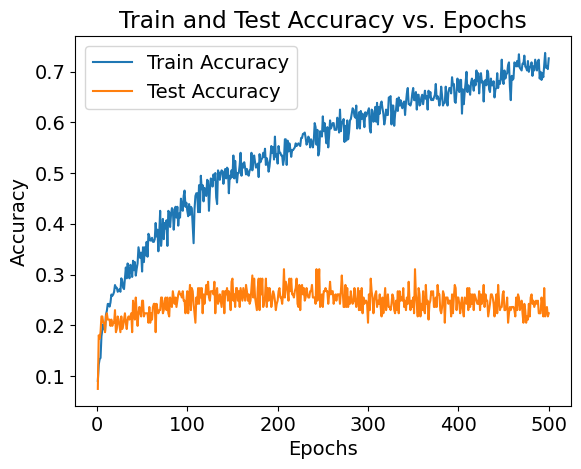

In [60]:
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.title('Train and Test Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/nethome/kcni/aaulakh/morphology/500_epochs_gnn.png')